<a href="https://colab.research.google.com/github/vaipathak/My-Projects/blob/master/FastAI_Classification_Projects/Dog_Cat_Classification/Dog_Cat_Classification_with_Fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The purpose of this notebook is to run an classifying algorithm that tries to differentiate between identifying cats and dogs with a low rate of error. We will use Fast.Ai as the classifier. 

**For Google Colab - Go to Edit > Notebook Settings > Hardware Accelorator (Click on GPU)**

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

After running the magics, we also import the fast.ai library files. 

In [0]:
from fastai.vision import * #imports all repositories from the fastai vision library.
from fastai.metrics import error_rate

We will first try a small batch size of 16 so as to avert any crashes. A batch size (bs) of 64 can be used if you have more gpu power. 

In [0]:
bs = 16
#bs = 64 if more gpu power can be obtained!

In [0]:
help(untar_data) #Essentially downloads data and unzips it to a file path
#The help function also shows you the "types" after the arguements. So the URL would be argument, the "str" is the type, in this case it's a string. fname (file name) is either a pathlibrary
#or a string from local drive


Help on function untar_data in module fastai.datasets:

untar_data(url:str, fname:Union[pathlib.Path, str]=None, dest:Union[pathlib.Path, str]=None, data=True, force_download=False) -> pathlib.Path
    Download `url` to `fname` if it doesn't exist, and un-tgz to folder `dest`.



In [0]:
path = untar_data(URLs.PETS); path #Download pets data into a repository called "path"

PosixPath('/root/.fastai/data/oxford-iiit-pet')

Let's take a look at what's inside the repository: 

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In the path, we have two folders - "annotations" and the actual "images". We can create variables to link to the folders in the path.

In [0]:
path_anno = path/'annotations' # This slash function lets you create a subpath  
path_img = path/'images'

Now we want to visualize what the data looks like. It's important to take a look so that we can understand a bit more about what the problem is. This means we get to understand how the data directories are structured, and what the annotations are, and of course, what some of the images look like.

In [0]:
fnames = get_image_files(path_img) #Grabs images from the path file and stores them in "fnames"
fnames[:5] #Shows the file names of the first 5 images

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Persian_152.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/english_setter_159.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_173.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Bengal_167.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_198.jpg')]

After looking at the file names, we can see that they even have names of certain dogs and cats. We can now use a "regular expression" algorithm to find a particular search pattern. We want to parse out the file name label from the path. Breaking it down: path('/root/.fastai/data/oxford-iiit-pet/images'), label(Sphynx), number, and extention (.jpg). To do AI, we need pictures, and we need labels.

For more information: https://en.wikipedia.org/wiki/Regular_expression

As well as: https://docs.python.org/3.6/library/re.html

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$' #This is the regular expression used in the "ImageDataBunch.from_name_re" regular expression to parse out the labels from the path

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)
#from_name_re is a regular expression library from python
#Breaking this down: 
#path_img is the path where the images are stored
#fnames is the list of file names
#pat is the regular expression pattern we are using to parse the labels from the file name
#size is we are telling what size images we are working with - important for the gpu to have all the images the same shape and size. Right now we will use only squares
#Size 224 x 224 is the most commonly parameter used in AI, but sometimes we want to play around with the size. 
#ds_tfms helps to transform our data to 224 by doing some center cropping and resizing it. 
#We have to normalize our data to the same mean and SD 
#Normalizing images means the pixel values start out at 255 and some channels (red, green, and blue) might be bright or not bright so we want to keep these similar to mean of 0 and SD of 1
#Not normalizing images could be a reason your AI model is having issues - so good to check for this. 

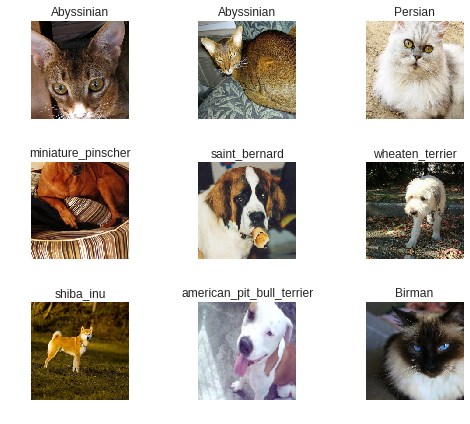

In [0]:
data.show_batch(rows = 3, figsize = (7,6)) #Taking a look at the data - making sure that there's no odd text covering it and that we can actually see something that makes sense!

In [0]:
print(data.classes) #All of the possible label names within our data - in this case there are 37
len(data.classes), data.c #Checks that the length matches. 
#A data bunch will always have a property called "c" which is essentially the number of classes (so can tell you similar what len does)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

Now we can start training the model by using a Convolutional Neural Network (This is a specic **learner**). We will be training this model with a CNN backbone and a fully connected head with a single hidden layer as a classifier. This all basically means that we are building a model which will take images as an inputand will output the predicted probability for each of the categories (in this case we will have 37 outputs)

We will train for 5 epochs (or 5 cycles through all our data)

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
#learner = cnn_learner
#data = our data bunch
#model or architecture - in this case, resnet
#metrics are a list of things that are printed out - in this case we are asking to print out the error rates
#resnet34 vs resnet50 (34 will train faster than 50)
#This will download the resnet34 pre-trained weights. Resnet34 has been pre-trained on a million images. So essentially our model is a smarter model than one that knows nothing. 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 68673481.77it/s]


We are going to now use "Transfer learning": This is where we take a pre-trained model that knows how to do something really well and it will predict the task that *we want*. This cuts costs on data and time needed. 

So how do we make sure our model isn't overfitting and cheating where it just luckily picks out the correct data. We do this by a validation set. In this case, we already have a validation set already created. 

In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.789534,0.337611,0.112991,02:14
1,0.562638,0.309806,0.104195,02:15
2,0.423412,0.248376,0.078484,02:12
3,0.303953,0.235086,0.072395,02:13


Total time: 2:49:46

epoch	train_loss	valid_loss	error_rate	time

0	0.749625	0.355450	            0.117727	 42:48

1	0.599145	0.309600	0.103518	42:18

2	0.471662	0.230369	0.079838	42:20

3	0.312349	0.223502	0.075101	42:19

Here is the output from the CNN learning. At the end of the 4th cycle (3), we have an error rate of 7%. 

So to sum up, what goes into our FastAI is the data.showbatch and now we will see what came out. This model is essetially creating a set of "weights" (similar to coefficients in linear/logistic regression)


In [0]:

learn.save('stage-1') #Saves our above trained weights in our directory of where the data is stored. 

**Results:**

Let's see which categories the model most confused with another category. We can try and see if the model was reasonable in its prediction and make sure there's no glaring miscategorization. 

Plotting the confusion matrix will also show that the distrbution is heavily skewed in that the model makes the same mistakes over and over again, but rarely confuses other categories - which suggests that it just finds it difficult to distinguish some specific categories between each other. 

In [0]:
interp = ClassificationInterpretation.from_learner(learn) #This is the confusion matrix 
#learn object knows two things 1) What's your data and 2) What is your model. This is a now a trained model. So this is all we need to interpret the model 

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

**NOTE**
"help()" will give some info on the function and parameters. "doc()" will show source of python code made to build the function. 

In [0]:
doc(ClassificationInterpretation)

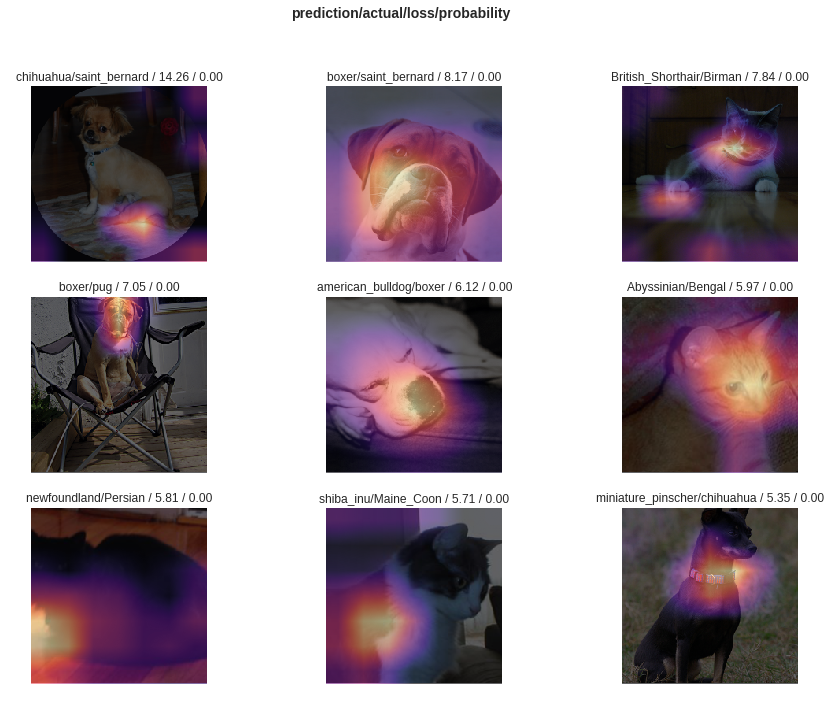

In [0]:
#Plotting the top losses:
interp.plot_top_losses(9, figsize = (15,11)) #From Docs: "Show images in `top_losses` along with their prediction, actual, loss, and probability of predicted class."


In [0]:
help(interp.plot_top_losses)

Help on method _cl_int_plot_top_losses in module fastai.vision.learner:

_cl_int_plot_top_losses(k, largest=True, figsize=(12, 12), heatmap:bool=True, heatmap_thresh:int=16, return_fig:bool=None) -> Union[matplotlib.figure.Figure, NoneType] method of fastai.train.ClassificationInterpretation instance
    Show images in `top_losses` along with their prediction, actual, loss, and probability of predicted class.



In [0]:
doc(interp.plot_top_losses)

Loss function - tells you how good was your prediction. ie if you predicted one class of cat with great confidence, but if you were wrong - then you have a high loss. 
So we want to see which ones were we the most wrong on. 

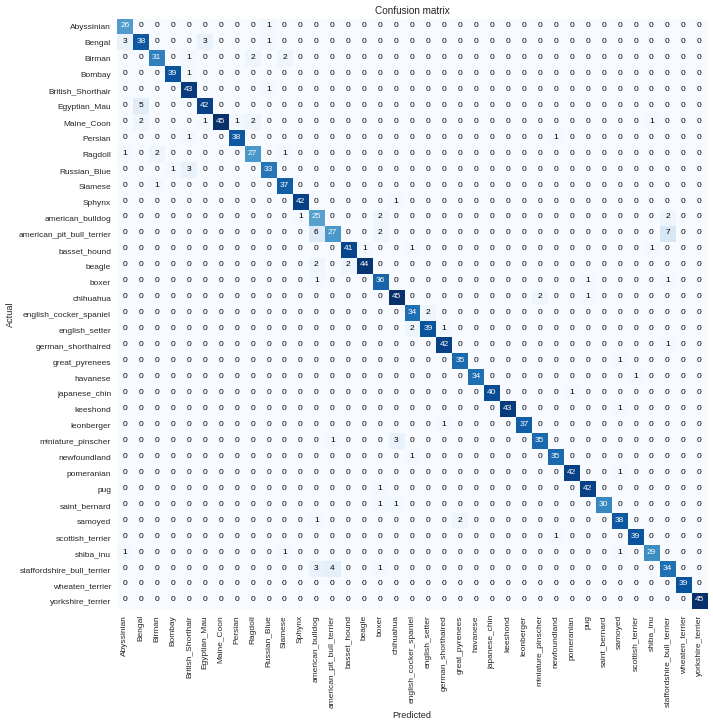

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60) #Confusion Matrix plot

This confusion matrix plot shows us for every actual dog or cat, how accurate did our model predict it. 

Since we have a lot of classes, instead of a confusion matrix, we can call one of the in house FastAI functions called "most_confused" - from the confusion matrix, this function grabs the particular combinations of predicted vs actual that were wrong the most.

In [0]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('american_pit_bull_terrier', 'american_bulldog', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Bengal', 'Abyssinian', 3),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Russian_Blue', 'British_Shorthair', 3),
 ('miniature_pinscher', 'chihuahua', 3),
 ('staffordshire_bull_terrier', 'american_bulldog', 3),
 ('Birman', 'Ragdoll', 2),
 ('Birman', 'Siamese', 2),
 ('Maine_Coon', 'Bengal', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Ragdoll', 'Birman', 2),
 ('american_bulldog', 'boxer', 2),
 ('american_bulldog', 'staffordshire_bull_terrier', 2),
 ('american_pit_bull_terrier', 'boxer', 2),
 ('beagle', 'american_bulldog', 2),
 ('beagle', 'basset_hound', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('english_cocker_spaniel', 'english_setter', 2),
 ('english_setter', 'english_cocker_spaniel', 2),
 ('samoyed', 'great_pyrenees', 2)]

Outputs:

[('staffordshire_bull_terrier', 'american_pit_bull_terrier', 8),

('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),

('Bengal', 'Abyssinian', 6) etc. 

Basically means that for the actual "Staffordshire Bull Terrier", the model predicted "American Pit Bull Terrier". 

This tool can give us a better idea if it makes sense why the model was confused (ie the data images are close to one another).
  
 

**Un-freezing, fine-tuning, and learning rates**

Since our model is working as we expect, we will *unfreeze* our model and train some more: 

In [0]:
learn.unfreeze() #trains the entire model, but trains with all the layers at the same speed / did not run this session

In [0]:
learn.fit_one_cycle(1) #did not run - but essentially the model does worse because of the unfreezing and unknown learning rate

In [0]:
learn.load('stage-1'); #Reloads our previously saved run

In [0]:
learn.lr_find() #Learning rate finder - tells us what is the fastest we can train our neural network at without it crashing off the rails and giving us bad error rates

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


The Learning rate says how quickly are we updating the parameters of our model. By viewing the plot, we can see which parameter allows for the best model fit. Note: the default parameter for learning rate is 1e-3. According to our plot, the highest learning rate we can go to is 1e-4. We can actually **slice** our learning so that we have a range: This will train the very first layers at 1e-6 and the very last layers at 1e-4. The rest of the layers are distributed accross between the two learning rates. 

Here is the plot we are making these assumptions on: (Unsure why plot looks different than from the lesson). 

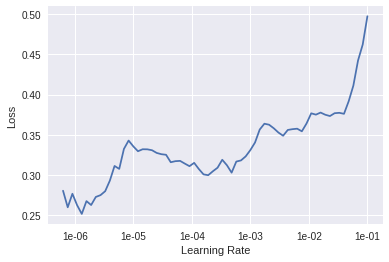

In [0]:
learn.recorder.plot()

Of course, resnet50 (adding more layers), may improve your accuracy. Now this could crash your GPU since it could run out of memory. 

In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.293911,0.233721,0.074425,02:19
1,0.296104,0.217924,0.066982,02:19


Using the 1e-6 and 1e-4 parameters, the error rate improved from 7.2% to 6.6%. 

Total time: 04:39

epoch	train_loss	valid_loss	error_rate	time

0	0.293911	0.233721	0.074425	02:19

1	0.296104	0.217924	0.066982	02:19